In [35]:
import bisect
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
import seaborn as sns
from networkx.drawing.nx_pydot import graphviz_layout
# import pydot
from google.cloud import storage

import dalmatian 
from fludarabine import model_helper 
from fludarabine.helper import *
from scipy.stats import iqr

In [3]:
# Load wbc and treatment file 
wbc_df = pd.read_csv('../../../data/gcll/CLL8 CLL cell count 10282024 UPDATED.csv')
treatment = pd.read_csv("../../../data/gcll/GCLL_treatment.txt", sep = '\t')

# Get input files from Terra through dalmatian
patient = 'GCLL-0115'
workspace ='broad-firecloud-ibmwatson/TAG_CLL_Clonal_Kinetic_UMI_PrAN'
wm = dalmatian.WorkspaceManager(workspace)

participants = wm.get_participants()


cluster_CCF_df = pd.read_csv(participants.loc[patient]['cluster_ccfs'], sep='\t')

abundance_df = pd.read_csv(participants.loc[patient]['abundances_tsv'], sep='\t')
mcmc_df = pd.read_csv(participants.loc[patient]['cell_population_mcmc_trace'], sep='\t')
tree_df = pd.read_csv(participants.loc[patient]['tree_tsv'], sep='\t')

In [9]:
# Select the wbc data for the patient

In [4]:
wbc_df_0115 = wbc_df[wbc_df['Patient'] == patient]
sample_list = wbc_df_0115['Timepoint'].dropna().tolist()

times_sample = [ int(i) for i in wbc_df_0115.loc[wbc_df_0115.Sample.notna(), 'Time_since_start_tx'].tolist()]
CLL_count = [float(i) for i in wbc_df_0115.loc[wbc_df_0115.Sample.notna(),'CLL count estm'].tolist()]

In [40]:
wbc_df_0115

,Pt no.,Patient,Date of diagnosis,Date of treatment,Date of sample,Time_since_start_tx,WBC,MRD,MRD negative,CLL count estm,Timepoint,Sample
211,20.0,GCLL-0115,6/7/01,4/3/06,3/15/06,-19,43.30,0.8600000000,0.0,37.23800000,GCLL-0115-T-01,CLL-GCLL-0115-Tumor-SM-41JXH
212,20.0,GCLL-0115,6/7/01,4/3/06,6/27/06,85,4.50,0.0020940707,0.0,0.00942332,GCLL-0115-MRD-01,CLL-GCLL-0115-Tumor-SM-7C9B5
213,20.0,GCLL-0115,6/7/01,4/3/06,9/14/06,164,4.50,0.0000000000,1.0,0.00000000,NaN,NaN
214,20.0,GCLL-0115,6/7/01,4/3/06,11/6/06,217,4.50,0.0000000000,1.0,0.00000000,NaN,NaN
215,20.0,GCLL-0115,6/7/01,4/3/06,2/6/07,309,4.50,0.0000000000,1.0,0.00000000,NaN,NaN
216,20.0,GCLL-0115,6/7/01,4/3/06,5/8/07,400,4.50,0.0000000000,1.0,0.00000000,NaN,NaN
217,20.0,GCLL-0115,6/7/01,4/3/06,8/28/07,512,4.50,0.0002145104,0.0,0.00096530,NaN,NaN
218,20.0,GCLL-0115,6/7/01,4/3/06,2/26/08,694,8.80,0.0084049983,0.0,0.07396399,GCLL-0115-MRD-02,CLL-GCLL-0115-Tumor-SM-7C9B6
219,20.0,GCLL-0115,6/7/01,4/3/06,6/9/08,798,9.40,0.0135274056,0.0,0.12715761,GCLL-0115-MRD-03,CLL-GCLL-0115-Tumor-SM-7C9B7
220,20.0,GCLL-0115,6/7/01,4/3/06,6/8/09,1162,19.40,0.3454524453,0.0,6.70177744,GCLL-0115-MRD-04,CLL-GCLL-0115-Tumor-SM-7C9B8


In [5]:
CLL_count

[37.238, 0.00942332, 0.07396399, 0.12715761, 6.70177744, 63.94]

In [6]:
times_sample

[-19, 85, 694, 798, 1162, 1431]

In [7]:
# Select the UMI timepoints with index
UMI_start = 1
UMI_end = 4

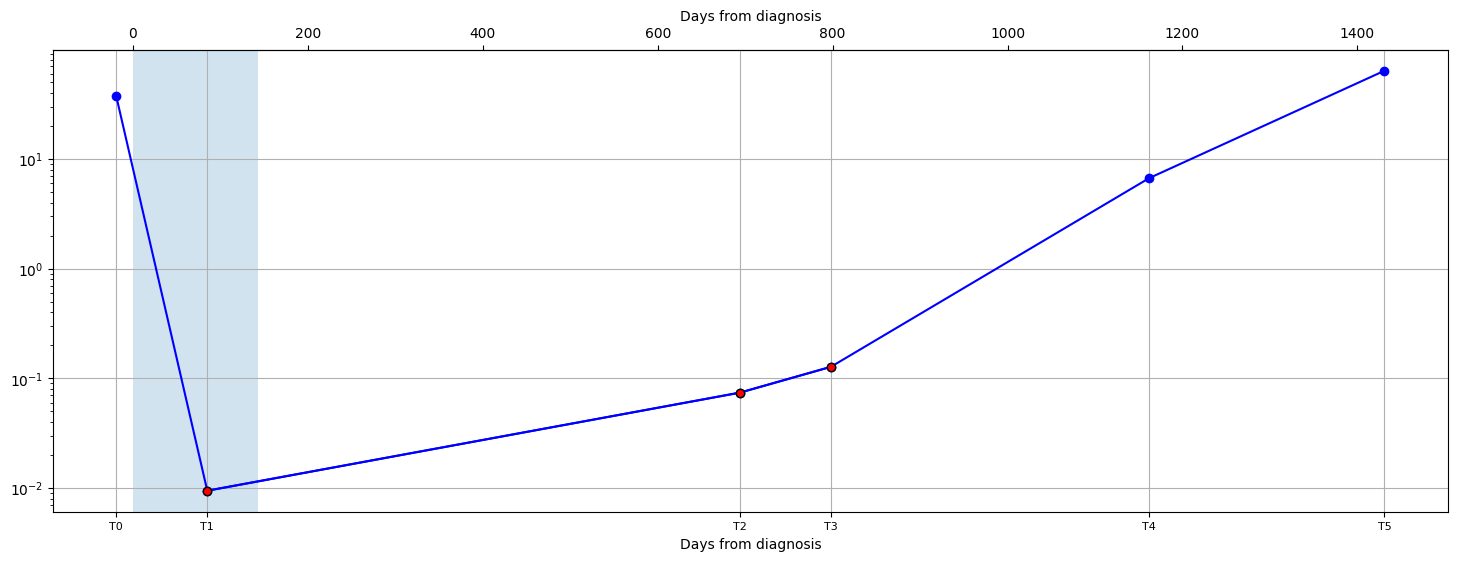

In [10]:
fig,ax = plt.subplots(1,1, figsize=(18,6))
ax.semilogy(times_sample,CLL_count,marker = 'o', color='blue')

# Create a scatter plot for the UMI timepoints with the red color
ax.semilogy(times_sample[UMI_start:UMI_end], CLL_count[UMI_start:UMI_end], color='blue',markerfacecolor='red',mec='black', marker = 'o')


# Fludarabine treatment 
ax.axvspan(xmin = 0, xmax= 143, label = "Fludarabine", alpha = 0.2)
ax.set_xlabel('Days from diagnosis')


number_samples = len(sample_list)
tick_list = ['T'+ str(i) for i in range(number_samples)]
ax.set_xticks(times_sample)
ax.set_xticklabels(tick_list, fontsize =8)

secax = ax.secondary_xaxis('top')
secax.set_xlabel('Days from diagnosis')
ax.grid(True)

Subclonal modeling

In [32]:
cluster_CCF_df

,Patient_ID,Sample_ID,Sample_Alias,Cluster_ID,postDP_ccf_mean,postDP_ccf_CI_low,postDP_ccf_CI_high,postDP_ccf_0.0,postDP_ccf_0.01,postDP_ccf_0.02,...,postDP_ccf_0.91,postDP_ccf_0.92,postDP_ccf_0.93,postDP_ccf_0.94,postDP_ccf_0.95,postDP_ccf_0.96,postDP_ccf_0.97,postDP_ccf_0.98,postDP_ccf_0.99,postDP_ccf_1.0
0,GCLL-0115,GCLL-0115-T-01,NaN,1,0.98,0.94,1.00,0.0,0.000000e+00,0.000000e+00,...,8.452303e-03,1.561124e-02,2.708335e-02,4.415187e-02,6.766109e-02,9.750354e-02,1.321673e-01,1.685649e-01,2.023265e-01,2.285957e-01
1,GCLL-0115,RP-1895_PDO-33508_SM-NKK1F_GCLL-0115-MRD-02_v1...,NaN,1,0.93,0.84,1.00,0.0,0.000000e+00,2.382000e-42,...,4.282183e-02,4.799157e-02,5.360100e-02,5.966499e-02,6.619673e-02,7.320731e-02,8.070487e-02,8.869582e-02,9.718317e-02,1.061667e-01
2,GCLL-0115,RP-1895_PDO-33508_SM-NKJZU_GCLL-0115-MRD-03_v1...,NaN,1,0.87,0.72,1.00,0.0,6.868016e-24,5.117534e-20,...,3.853871e-02,4.037613e-02,4.223593e-02,4.411470e-02,4.600881e-02,4.791493e-02,4.982915e-02,5.174795e-02,5.366750e-02,5.558409e-02
3,GCLL-0115,RP-1895_PDO-33508_SM-NKK1K_GCLL-0115-MRD-04_v1...,NaN,1,1.00,0.99,1.00,0.0,0.000000e+00,0.000000e+00,...,2.420789e-09,2.783614e-08,2.994605e-07,3.017921e-06,2.852711e-05,2.532294e-04,2.113416e-03,1.660214e-02,1.228933e-01,8.581061e-01
4,GCLL-0115,GCLL-0115-T-02,NaN,1,0.98,0.95,1.00,0.0,0.000000e+00,0.000000e+00,...,3.760586e-03,9.137671e-03,1.986823e-02,3.867852e-02,6.744978e-02,1.054090e-01,1.476789e-01,1.855378e-01,2.090841e-01,2.113777e-01
5,GCLL-0115,GCLL-0115-T-01,NaN,2,0.15,0.12,0.18,0.0,1.152700e-41,1.114889e-27,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6,GCLL-0115,RP-1895_PDO-33508_SM-NKK1F_GCLL-0115-MRD-02_v1...,NaN,2,0.86,0.71,1.00,0.0,1.230000e-42,6.326281e-35,...,3.818800e-02,3.881846e-02,3.933774e-02,3.974371e-02,4.003557e-02,4.021281e-02,4.027652e-02,4.022854e-02,4.007147e-02,3.980865e-02
7,GCLL-0115,RP-1895_PDO-33508_SM-NKJZU_GCLL-0115-MRD-03_v1...,NaN,2,0.87,0.72,1.00,0.0,2.800766e-28,1.607557e-23,...,3.884912e-02,4.048509e-02,4.210972e-02,4.371825e-02,4.530536e-02,4.686653e-02,4.839695e-02,4.989164e-02,5.134642e-02,5.275681e-02
8,GCLL-0115,RP-1895_PDO-33508_SM-NKK1K_GCLL-0115-MRD-04_v1...,NaN,2,1.00,1.00,1.00,0.0,0.000000e+00,0.000000e+00,...,2.557495e-14,1.144543e-12,4.700588e-11,1.774634e-09,6.168924e-08,1.977626e-06,5.855654e-05,1.603798e-03,4.069032e-02,9.576454e-01
9,GCLL-0115,GCLL-0115-T-02,NaN,2,0.96,0.92,1.00,0.0,0.000000e+00,0.000000e+00,...,3.543445e-02,5.888670e-02,8.725295e-02,1.153265e-01,1.360359e-01,1.432550e-01,1.347185e-01,1.131632e-01,8.492083e-02,5.693740e-02


In [33]:
times_sample

[-19, 85, 694, 798, 1162, 1431]

ValueError: x and y must have same first dimension, but have shapes (6,) and (5,)

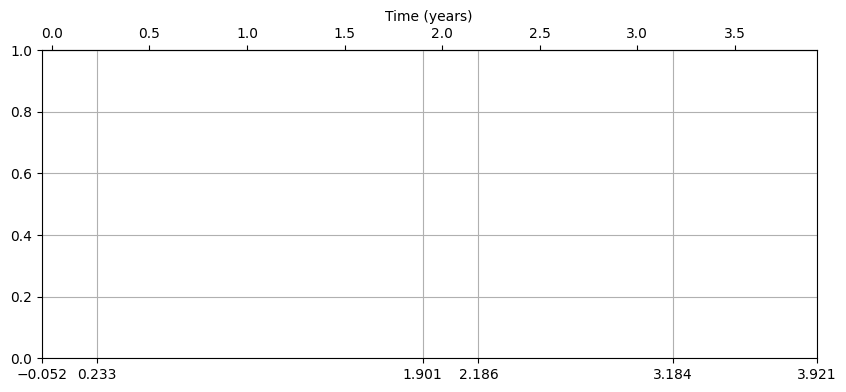

In [36]:
fig, ax = plt.subplots(figsize = (10, 4))
model_helper.plot_ccf(cluster_CCF_df,ax, times_sample, treatment)

In [12]:
abundance_df.Sample_ID.unique()

array(['RP-1895_PDO-33508_SM-NKK1F_GCLL-0115-MRD-02_v1_Custom_Selection_OnPrem',
       'RP-1895_PDO-33508_SM-NKJZU_GCLL-0115-MRD-03_v1_Custom_Selection_OnPrem',
       'RP-1895_PDO-33508_SM-NKK1K_GCLL-0115-MRD-04_v1_Custom_Selection_OnPrem',
       'GCLL-0115-T-02', 'GCLL-0115-T-01'], dtype=object)

In [12]:
# Manually verify the sample list order is correct

In [13]:
sample_list = ['GCLL-0115-T-01','RP-1895_PDO-33508_SM-NKK1F_GCLL-0115-MRD-02_v1_Custom_Selection_OnPrem','RP-1895_PDO-33508_SM-NKJZU_GCLL-0115-MRD-03_v1_Custom_Selection_OnPrem',
               'RP-1895_PDO-33508_SM-NKK1K_GCLL-0115-MRD-04_v1_Custom_Selection_OnPrem',
 'GCLL-0115-T-02']

In [14]:
cluster_list, cluster_abundance = model_helper.get_abundance(abundance_df, mcmc_df, sample_list)

In [15]:
cluster_list

[1, 2, 3, 4, 5, 6]

In [16]:
cluster_abundance

{1: [0.44, 0.0, 0.0, 0.0, 0.0],
 2: [0.13, 0.85, 0.64, 0.61, 0.47],
 3: [0.01, 0.07, 0.02, 0.32, 0.44],
 4: [0.33, 0.0, 0.0, 0.0, 0.0],
 5: [0.01, 0.02, 0.22, 0.06, 0.06],
 6: [0.06, 0.02, 0.0, 0.01, 0.01]}

In [17]:
# calculate only at sample points
subclone_sample, log_subclone_sample = model_helper.calc_subclone(CLL_count, cluster_abundance, cluster_list)


In [18]:
all_abundance = model_helper.get_all_abundance(cluster_list, mcmc_df, sample_list, times_sample, )

In [19]:
#  Add noise to all abundance

import random 

def add_uniform_noise_and_normalize(lst, low=0, high=0.01):
    
    # Add uniform noise
    noisy_lst = [x + random.uniform(low, high) for x in lst]

    
    # Normalize the list
    total_sum = sum(noisy_lst)
    
    normalized_lst = [x / total_sum for x in noisy_lst]

    return normalized_lst


subclone_cluster_iter = {}
# Iterate through each cluster
for cluster, iterations in all_abundance.items():
   
    # Iterate through each iteration in the cluster
    for iteration, value in iterations.items():
        # If the iteration is not in the new dict, add it
        if iteration not in subclone_cluster_iter:
            subclone_cluster_iter[iteration] = {}
        # Add the cluster and its value to this iteration
        subclone_cluster_iter[iteration][cluster] = value

        
        
noise_added_iter = {}

for iteration, abundances in subclone_cluster_iter.items():
    
    transposed_data = {i: list(values) for i, values in enumerate(zip(*abundances.values()), start=1)}
    
    noise_added_iter[iteration] = {}
    for time_point, abundance in transposed_data.items():
        
#         print(time_point, abundance)
        noise_abundance = add_uniform_noise_and_normalize(abundance)
    
#         print(noise_abundance)

        noise_added_iter[iteration][time_point] = add_uniform_noise_and_normalize(abundance)

    
noise_added_all_abundance = {}
for iteration, abundances in noise_added_iter.items():
    original_format = {i + 1: list(values) for i, values in enumerate(zip(*abundances.values()))}
    noise_added_all_abundance[iteration] = original_format
    
    
noise_added_original_all_abundances = {}

for iteration, abundances in noise_added_all_abundance.items():
    
    for cluster, abundance_value in abundances.items():
        if cluster not in noise_added_original_all_abundances:
            noise_added_original_all_abundances[cluster] = {}
        noise_added_original_all_abundances[cluster][iteration] = abundance_value
            

In [20]:
all_abundance

{1: {0: [0.39, 0.0, 0.12, 0.0, 0.0],
  1: [0.37, 0.16, 0.14, 0.0, 0.02],
  2: [0.43, 0.04, 0.0, 0.0, 0.0],
  3: [0.44, 0.11, 0.0, 0.0, 0.02],
  4: [0.45, 0.04, 0.0, 0.0, 0.0],
  5: [0.3, 0.0, 0.0, 0.0, 0.01],
  6: [0.34, 0.0, 0.0, 0.0, 0.0],
  7: [0.35, 0.15, 0.0, 0.0, 0.01],
  8: [0.4, 0.0, 0.03, 0.0, 0.09],
  9: [0.39, 0.0, 0.07, 0.0, 0.01],
  10: [0.38, 0.14, 0.0, 0.0, 0.0],
  11: [0.42, 0.0, 0.0, 0.0, 0.01],
  12: [0.37, 0.0, 0.0, 0.0, 0.05],
  13: [0.39, 0.05, 0.1, 0.0, 0.05],
  14: [0.41, 0.0, 0.0, 0.0, 0.05],
  15: [0.41, 0.0, 0.0, 0.0, 0.01],
  16: [0.38, 0.18, 0.0, 0.0, 0.02],
  17: [0.4, 0.0, 0.0, 0.0, 0.0],
  18: [0.39, 0.16, 0.0, 0.0, 0.03],
  19: [0.41, 0.09, 0.0, 0.0, 0.02],
  20: [0.38, 0.13, 0.0, 0.0, 0.0],
  21: [0.32, 0.03, 0.0, 0.0, 0.09],
  22: [0.41, 0.21, 0.0, 0.0, 0.0],
  23: [0.47, 0.0, 0.0, 0.0, 0.0],
  24: [0.37, 0.0, 0.0, 0.0, 0.0],
  25: [0.44, 0.02, 0.0, 0.0, 0.04],
  26: [0.43, 0.0, 0.14, 0.0, 0.01],
  27: [0.41, 0.06, 0.0, 0.0, 0.04],
  28: [0.39, 0.0, 0.

In [21]:
noise_added_original_all_abundances

{1: {0: [0.40429712569670573,
   0.006982024874148309,
   0.12333229271900581,
   0.004455188553993126,
   0.005710917684196341],
  1: [0.37994507538533073,
   0.1647267073842058,
   0.1605809545726128,
   0.008594732175947055,
   0.02065556297789986],
  2: [0.4354261163960158,
   0.041688642490417434,
   0.007668179512568546,
   0.0018869948527747585,
   0.009521093282944846],
  3: [0.4406996241995007,
   0.12008048880922678,
   0.008476243576548958,
   0.003361409097865588,
   0.028674998772191724],
  4: [0.437996594695622,
   0.04489491006315509,
   0.010835958305044644,
   0.005242350512094752,
   0.003857249890802073],
  5: [0.30257190413064955,
   0.008023218338691865,
   0.007782600531054732,
   0.0035141352267347636,
   0.015384492879592548],
  6: [0.35039742430581816,
   0.008421105083959974,
   0.006586205586129439,
   0.0017684819998114458,
   0.0029578505492962805],
  7: [0.34274695536805283,
   0.1619357537410952,
   0.0026421336701004244,
   0.0017467512115622197,
   0.01

In [22]:
subclone_sample_mcmc_with_uniform_noise, log_subclone_sample_mcmc_with_uniform_noise = model_helper.calc_subclone(CLL_count, noise_added_original_all_abundances, cluster_list, input_type = "mcmc")

In [23]:
times_sample

[-19, 85, 694, 798, 1162, 1431]

In [24]:
# Get the times at the start of the treatment and after 
all_times = [int(i) for i in wbc_df_0115['Time_since_start_tx'].to_list()]

times_aft_tx = [x for x in all_times if x > 143]
times_aft_tx.insert(0, 143)

In [25]:
times_aft_tx

[143, 164, 217, 309, 400, 512, 694, 798, 1162, 1431]

In [26]:
# Linear Regression Modeling

In [27]:
CLL_count

[37.238, 0.00942332, 0.07396399, 0.12715761, 6.70177744, 63.94]

In [28]:
# Set the extrapolate time after treatment
extrapolate_start_idx = 2
# extrapolate_end_idx = 6

extrapolate_times =times_sample[extrapolate_start_idx:]

In [37]:
extrapolate_times

[694, 798, 1162, 1431]

In [38]:
times_sample

[-19, 85, 694, 798, 1162, 1431]

In [39]:
log_subclone_sample[1]

[2.7965764401087694,
 -13.874908182849417,
 -11.814517297814497,
 -11.272668310310973,
 -7.307967591210074]

ValueError: x and y must be the same size

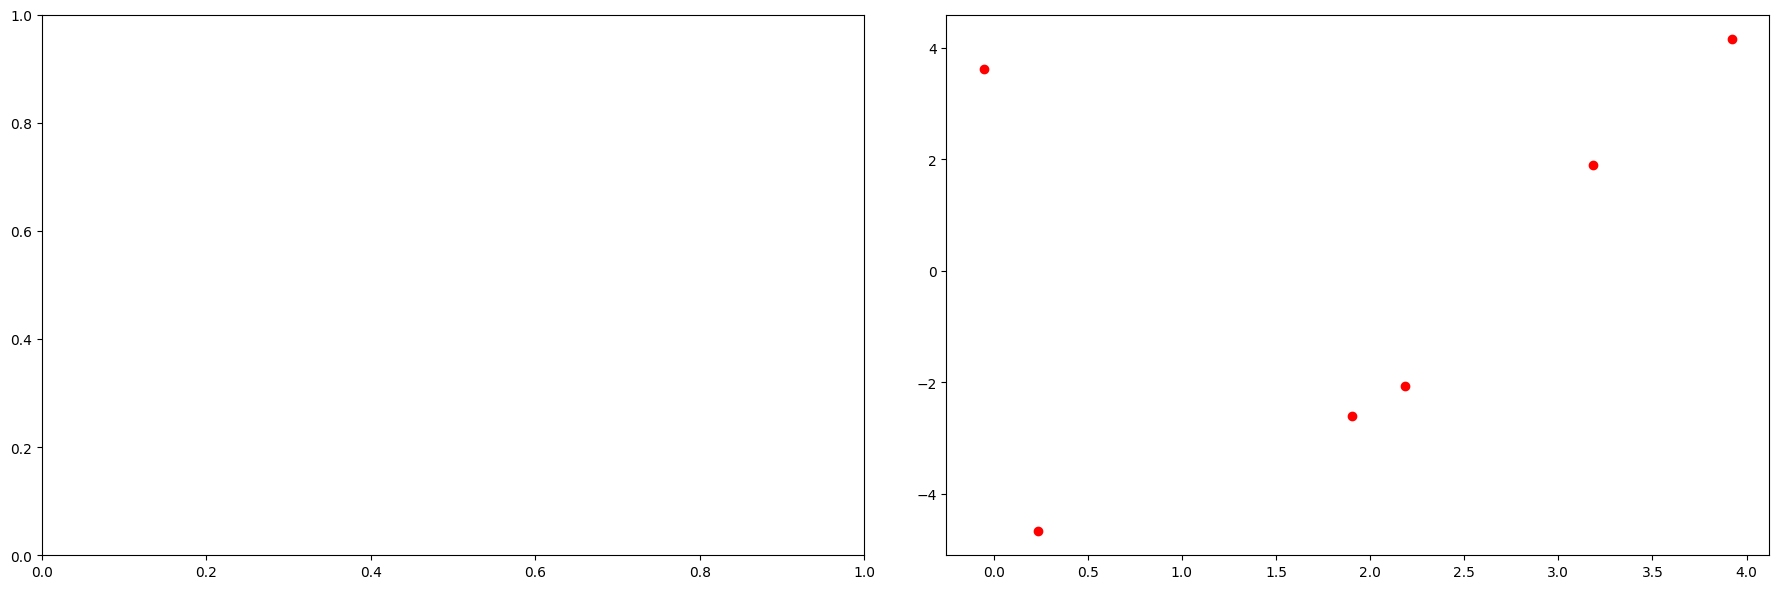

In [31]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]

predicted_end_tx_clones = []

def plot_sub(ax, clusters):
    
        
    # plot total wbc
    
    x_year = [ i/365 for i in np.array(times_sample)]
    ax.scatter(x_year,np.log(CLL_count), label = 'CLL count estimate', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}
    
    for i in clusters:
        x_year = [ i/365 for i in np.array(times_sample)]
        y_sub = np.array(log_subclone_sample[i])
        ax.scatter(x_year,y_sub, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)


        # Extrapolate after treatment
        extrapolate_times =times_sample[extrapolate_start_idx:]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = log_subclone_sample[i][extrapolate_start_idx:]
        
        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

        predict_x = times_aft_tx
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        
        predicted_end_tx_clones.append(predicted[0])
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))


    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log CLL count estimates $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    # add potential UMI samples
    # ax.axvline(x=952/365,  color = 'red')
    # ax.axvline(x=1012/365, label ='UMI',color = 'red')

# model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_sub(ax2, [1,2,3, 4,5,6])
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')




## Assume exponential decrease during treatment and constant subclonal composition before treatment 

 
times_during_tx = [0,143/365]

tx_start_clones=[]
clusters = [1,2,3, 4]
for i in clusters:
    tx_start_clones.append(log_subclone_sample[i][0])




for i in clusters:
    ax2.plot(times_during_tx, [tx_start_clones[i-1], predicted_end_tx_clones[i-1]], color=ClusterColors.get_hex_string(i), marker = 'o')




In [30]:
# Adding all the iterations

In [31]:
subclone_sample_mcmc_with_uniform_noise[1][0]

[119.8263738894978,
 0.009867616621470654,
 0.07374741997673225,
 0.26351096777285554,
 2.1439145480827153]

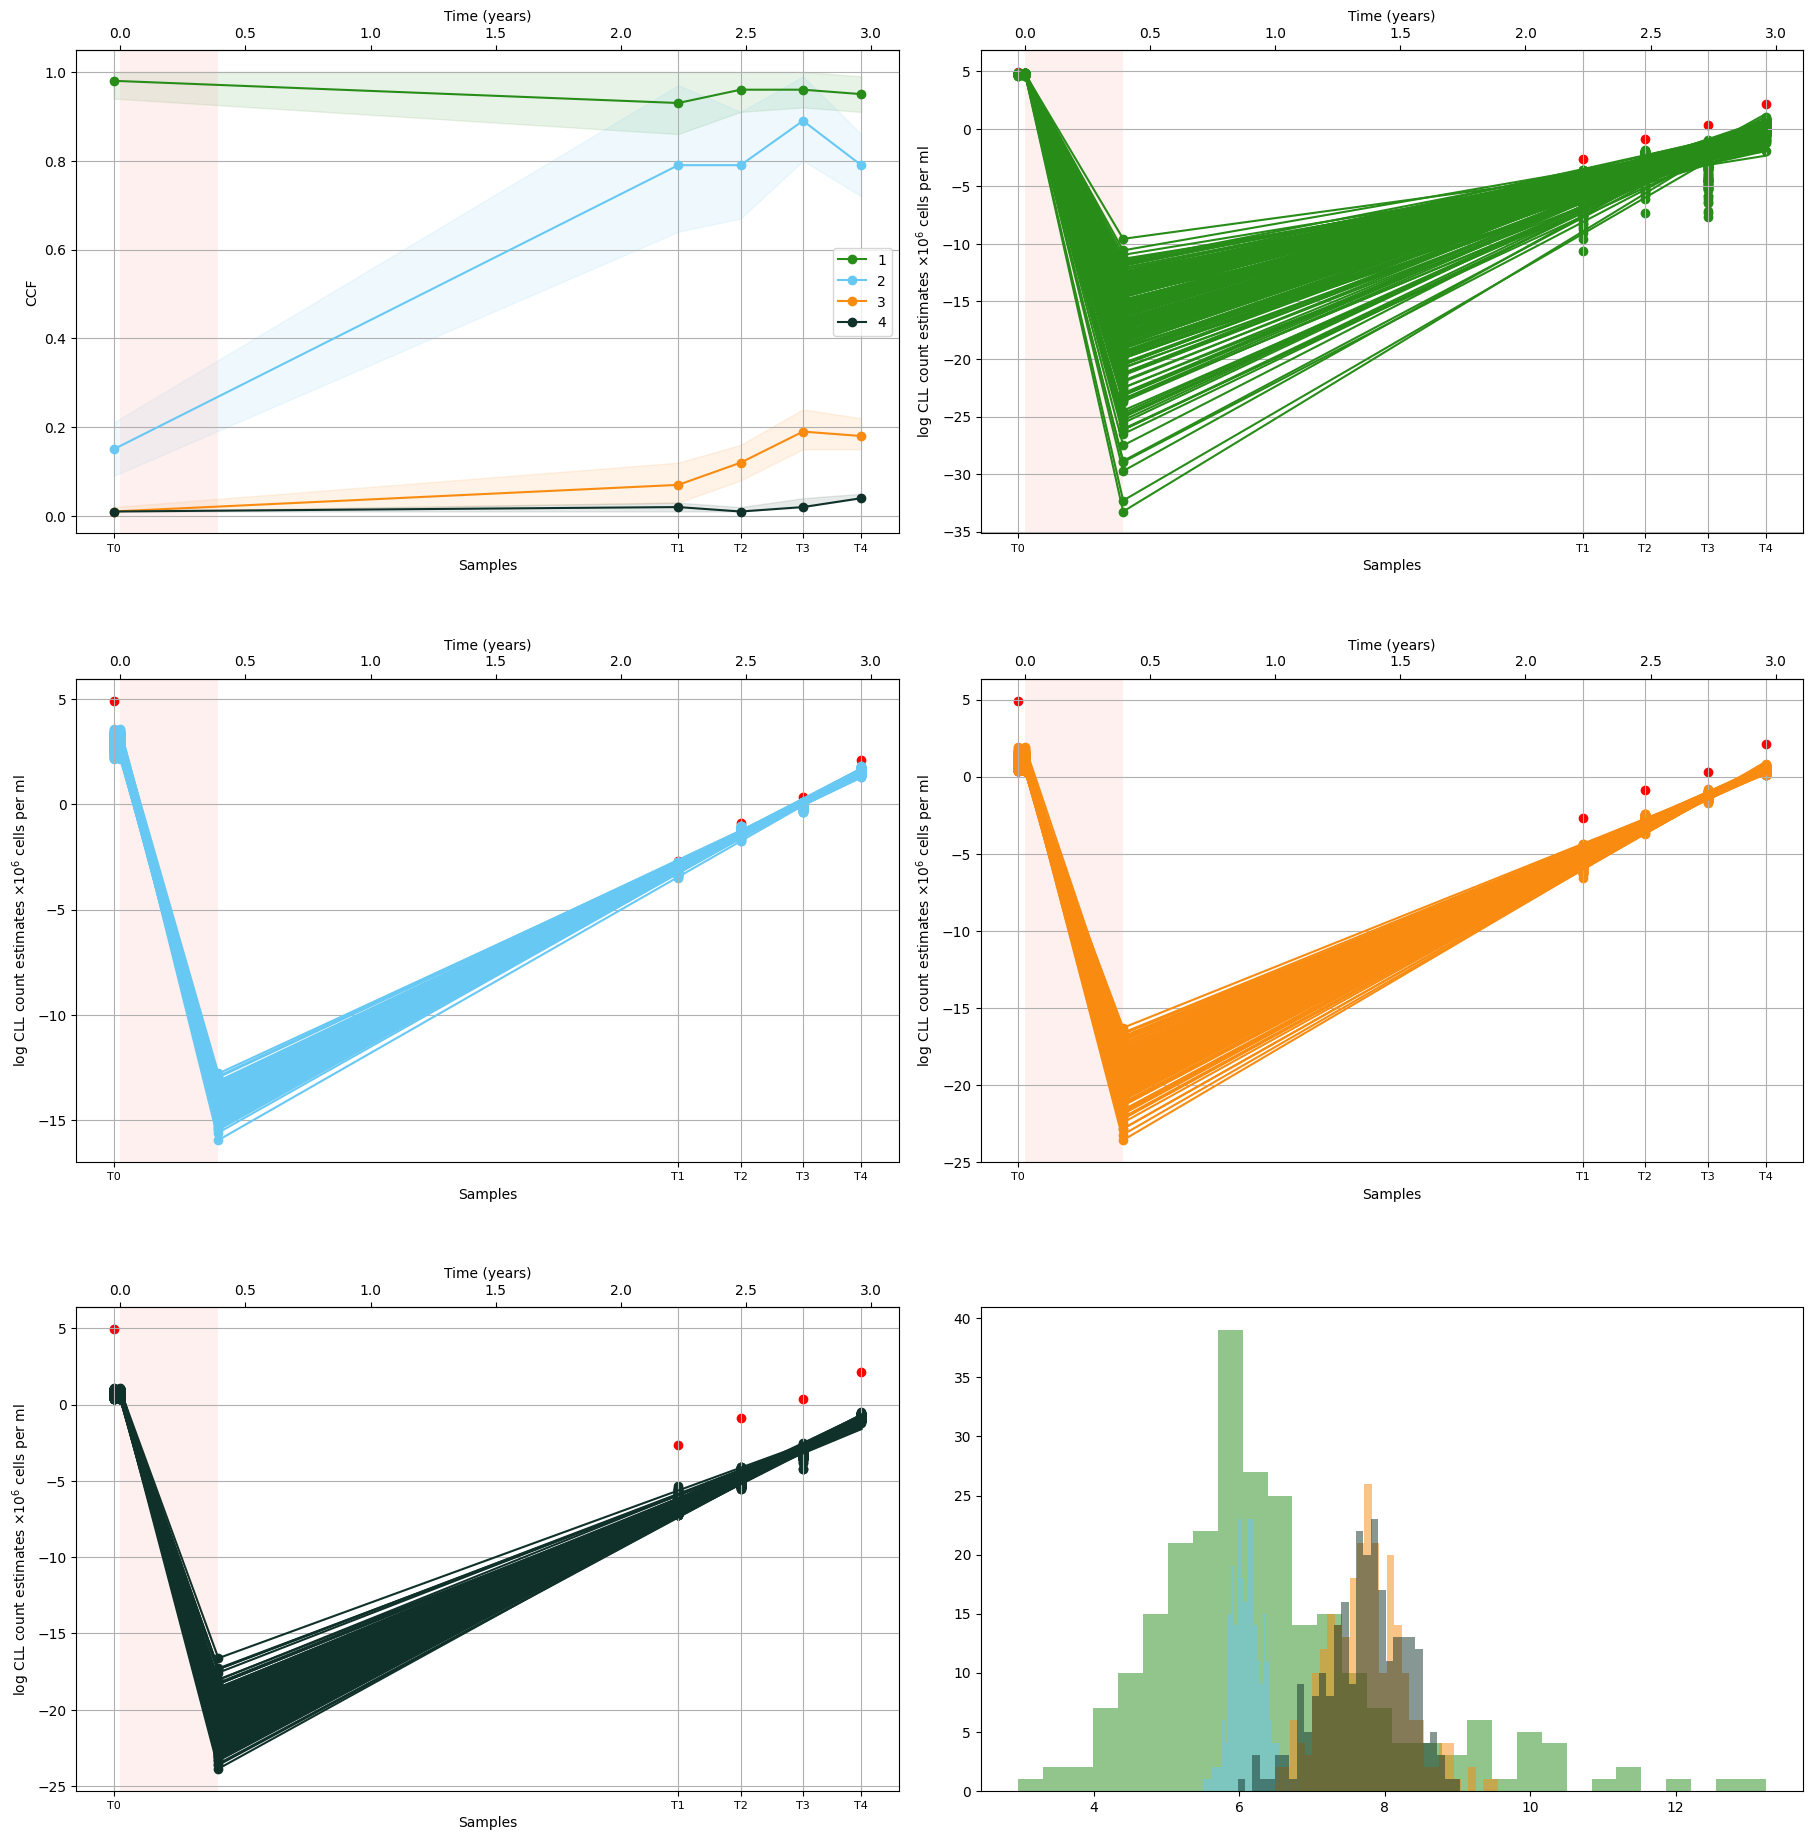

In [32]:
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(18,18))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]




slopes_mcmc = {}
def plot_sub_mcmc(ax, cluster):
    
        
    # plot total wbc
    
    x_year = [ i/365 for i in np.array(times_sample)]
    ax.scatter(x_year,np.log(CLL_count), label = 'CLL count estimate', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}
    
    
    slopes_mcmc[cluster]=[]
    for iter_idx in range(250):
        
        x_year = [ i/365 for i in np.array(times_sample)]
        y_sub = np.array(log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx])
        ax.scatter(x_year,y_sub,c= ClusterColors.get_hex_string(cluster),)


        # Extrapolate after treatment
        extrapolate_times = times_sample[extrapolate_start_idx:]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx][extrapolate_start_idx:]

        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)
        
        slopes_mcmc[cluster].append(model[0])
        

        predict_x = times_aft_tx
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        
        predicted_end_tx_clones.append(predicted[0])
        ax.plot(predict_year, predicted, color=ClusterColors.get_hex_string(cluster))


        times_during_tx = [0,143/365]

       

        tx_start_clones = log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx][0]

        
        ax.plot(times_during_tx, [tx_start_clones, predicted[0]], color=ClusterColors.get_hex_string(cluster), marker = 'o')

        
    


    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log CLL count estimates $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    # add potential UMI samples
    # ax.axvline(x=952/365,  color = 'red')
    # ax.axvline(x=1012/365, label ='UMI',color = 'red')

model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_sub_mcmc(ax2, 1)
plot_sub_mcmc(ax3, 2)
plot_sub_mcmc(ax4, 3)
plot_sub_mcmc(ax5, 4)
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')


for cluster in clusters:
    ax6.hist(slopes_mcmc[cluster], alpha=0.5,color=ClusterColors.get_hex_string(cluster), bins = 30)


In [33]:
for cluster in clusters:
    mean = np.mean(slopes_mcmc[cluster], axis=0)
    lower_ci = np.percentile(slopes_mcmc[cluster], 2.5, axis=0)
    upper_ci = np.percentile(slopes_mcmc[cluster], 97.5, axis=0)
    print(f"Cluster: {cluster}, mean:{mean:.4f}, 95% Confidence Interval: {lower_ci:.4f} to {upper_ci:.4f}")
    
    

Cluster: 1, mean:6.4632, 95% Confidence Interval: 4.0916 to 10.4524
Cluster: 2, mean:6.1115, 95% Confidence Interval: 5.6945 to 6.5312
Cluster: 3, mean:7.7486, 95% Confidence Interval: 6.7806 to 8.8859
Cluster: 4, mean:7.7201, 95% Confidence Interval: 6.5779 to 8.6624
